In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob2 import glob
import dask.array

In [2]:
swot_files = sorted(glob('./SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/*.nc'))
swot_files[10:20]

['./SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_006_022_20111118T170604_20111118T175710_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_006_026_20111118T203027_20111118T212132_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_007_002_20111118T235448_20111119T004554_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_007_012_20111119T082546_20111119T091650_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_007_015_20111119T105902_20111119T115007_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_008_021_20111120T155613_20111120T164718_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_008_025_20111120T192035_20111120T201141_DG10_01.nc',
 './SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_009_001_20111

In [3]:
swot_ds = xr.open_mfdataset(swot_files[10:22], combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})
swot_ds

<xarray.Dataset>
Dimensions:                                (num_lines: 118402, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(9868,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(9868,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/92)
    time                                   (num_lines) datetime64[ns] dask.array<chunksize=(9868,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] dask.array<chunksize=(9868,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
    simulated_error_troposphere            (num_lines, num_pixels) float64 dask.array<chunksize=(9868, 71), meta=np.ndarray>
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-23 07:47:28Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       67.57445067787674
    right_last_latitude:        -78.29237200613302
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.0033528106647474805

In [16]:
# Assuming swot_ds is your dataset
# Extract the nadir position for the ground track
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values
latitude = swot_ds['latitude'].values
longitude = swot_ds['longitude'].values

In [20]:
aviso_path = './aviso_msla_ccs_1d.nc'
aviso_ds = xr.open_dataset(aviso_path)
aviso_ssh = aviso_ds.msla[:, :, 0].data
lon, lat = aviso_ds.lon.data, aviso_ds.lat.data

In [58]:
import numpy as np

def extract_aviso_within_swot_bounds(msla, lon, lat, swot_longitude, swot_latitude):
    # Define the bounds for California Current region
    cc_bounds = {
        "lon": [360-150, 360-115],
        "lat": [25, 50]
    }

    # Filter SWOT data points within the California Current bounds
    valid_swot_mask = (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & \
                      (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    swot_longitude = swot_longitude[valid_swot_mask]
    swot_latitude = swot_latitude[valid_swot_mask]

    # Find bounding rectangle
    min_lon, max_lon = np.min(swot_longitude), np.max(swot_longitude)
    min_lat, max_lat = np.min(swot_latitude), np.max(swot_latitude)

    # Calculate center
    center_lon, center_lat = (min_lon + max_lon) / 2, (min_lat + max_lat) / 2

    # Get the bounding points for each quadrant
    q1 = np.argmax(np.sqrt((swot_longitude - center_lon)**2 + (swot_latitude - center_lat)**2) * ((swot_longitude > center_lon) & (swot_latitude > center_lat)))
    q2 = np.argmax(np.sqrt((swot_longitude - center_lon)**2 + (swot_latitude - center_lat)**2) * ((swot_longitude < center_lon) & (swot_latitude > center_lat)))
    q3 = np.argmax(np.sqrt((swot_longitude - center_lon)**2 + (swot_latitude - center_lat)**2) * ((swot_longitude < center_lon) & (swot_latitude < center_lat)))
    q4 = np.argmax(np.sqrt((swot_longitude - center_lon)**2 + (swot_latitude - center_lat)**2) * ((swot_longitude > center_lon) & (swot_latitude < center_lat)))

    bounding_lons = [min_lon, max_lon, swot_longitude[q1], swot_longitude[q2], swot_longitude[q3], swot_longitude[q4]]
    bounding_lats = [min_lat, max_lat, swot_latitude[q1], swot_latitude[q2], swot_latitude[q3], swot_latitude[q4]]

    # Generate a meshgrid from the lon and lat arrays
    LON, LAT = np.meshgrid(lon, lat)

    # Apply polygon mask to filter msla data
    from matplotlib.path import Path

    path = Path(list(zip(bounding_lons, bounding_lats)))
    points = np.vstack((LON.ravel(), LAT.ravel())).T
    grid = path.contains_points(points).reshape(LON.shape)

    msla_filtered = np.where(grid, msla, np.nan)

    return LON, LAT, msla_filtered


In [116]:


def extract_aviso_within_swot_bounds(msla, lon, lat, swot_longitude, swot_latitude):
    
    
    import numpy as np
    
    
    # Define the bounds for California Current region
    cc_bounds = {
        "lon": [360-150, 360-115],
        "lat": [25, 50]
    }

    # Identify the SWOT points that intersect the CCS bounds
    intersect_mask = (
        (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & 
        (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    )

    intersected_lons = swot_longitude[intersect_mask]
    intersected_lats = swot_latitude[intersect_mask]
    
    # For the purpose of demonstration, I will use a simple nearest neighbor interpolation on the AVISO grid
    # This approach might not be the best depending on your data distribution, so consider other interpolation techniques if needed.
    msla_interpolated = np.ones_like(msla) * 1e20
    for s_lon, s_lat in zip(intersected_lons, intersected_lats):
        nearest_lon_idx = np.abs(lon - s_lon).argmin()
        nearest_lat_idx = np.abs(lat - s_lat).argmin()
        
        msla_interpolated[nearest_lat_idx, nearest_lon_idx] = msla[nearest_lat_idx, nearest_lon_idx]
        
    msla_interpolated = np.ma.masked_equal(msla_interpolated, 1e20)

    return lon, lat, msla_interpolated


In [117]:
# Test the function with your data
swot_longitude = longitude  # Assuming 'longitude' is defined somewhere in your environment
swot_latitude = latitude  # Assuming 'latitude' is defined somewhere in your environment
LON, LAT, msla_filtered = extract_aviso_within_swot_bounds(aviso_ssh, lon, lat, swot_longitude, swot_latitude)

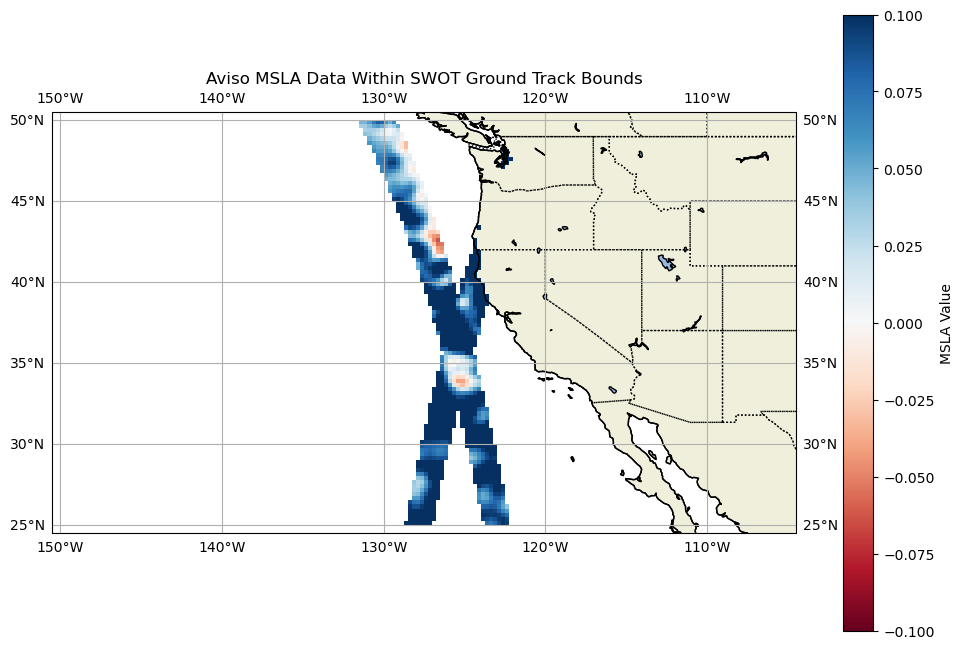

In [120]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ... [Your function or data loading code]

# Plotting on a 2D map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set background color to white
# ax.background_patch.set_facecolor('white')
plt.pcolormesh(lon, lat, msla_filtered, cmap= 'RdBu', vmin = -.1, vmax = 0.1)
plt.colorbar(label='MSLA Value')
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.gridlines(draw_labels=True)
plt.title('Aviso MSLA Data Within SWOT Ground Track Bounds')
plt.savefig("./selected_aviso_ssh.png")


In [119]:
msla_filtered

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)